In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 21 11:44:19 2021

@author: pmeurice
"""
from tensorflow import keras
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
import os,PIL
from tqdm import tqdm

C:\Users\adelabrosse\AppData\Local\Temp\ipykernel_18008\1148425458.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [67]:
input_dir = "données/donnees_traitees/input-ortho-256" # "/Users/pmeurice/Documents/Projets/IGN-DSB/ML/data/inputs-ortho-256/"
target_dir = "données/donnees_traitees/annotations-256" # "/Users/pmeurice/Documents/Projets/IGN-DSB/ML/data/annotations-256/"
img_size = (256, 256)
batch_size = 32
#input_dir = "/Users/pmeurice/Documents/Projets/IGN-DSB/ML/data/inputs/"
#target_dir = "/Users/pmeurice/Documents/Projets/IGN-DSB/ML/data/annotations/"
#img_size = (512, 512)
#batch_size = 16

output_dir = "output_photos/" # "/Users/pmeurice/Documents/Projets/IGN-DSB/ML/data/outputs/"
model_dir = "output_model/" # "/Users/pmeurice/Documents/Projets/IGN-DSB/ML/data/model/"
num_classes = 2
num_samples = 500 # 16384
seed = 1337
sigma = 1.6
epochs = 2

In [54]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of samples:", len(input_img_paths))


input_img_paths = input_img_paths[0:num_samples]
target_img_paths = target_img_paths[0:num_samples]

print("Number of samples used:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1035
Number of samples used: 500
données/donnees_traitees/input-ortho-256\35-2020-0305-6780-0000-0000-050M-ortho.jpg | données/donnees_traitees/annotations-256\35-2020-0305-6780-0000-0000-050M-mask.png
données/donnees_traitees/input-ortho-256\35-2020-0305-6780-0000-0256-050M-ortho.jpg | données/donnees_traitees/annotations-256\35-2020-0305-6780-0000-0256-050M-mask.png
données/donnees_traitees/input-ortho-256\35-2020-0305-6780-0000-0512-050M-ortho.jpg | données/donnees_traitees/annotations-256\35-2020-0305-6780-0000-0512-050M-mask.png
données/donnees_traitees/input-ortho-256\35-2020-0305-6780-0000-0768-050M-ortho.jpg | données/donnees_traitees/annotations-256\35-2020-0305-6780-0000-0768-050M-mask.png
données/donnees_traitees/input-ortho-256\35-2020-0305-6780-0000-1024-050M-ortho.jpg | données/donnees_traitees/annotations-256\35-2020-0305-6780-0000-1024-050M-mask.png
données/donnees_traitees/input-ortho-256\35-2020-0305-6780-0000-1280-050M-ortho.jpg | données/donnees_t

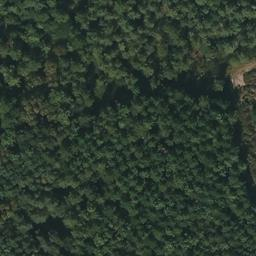

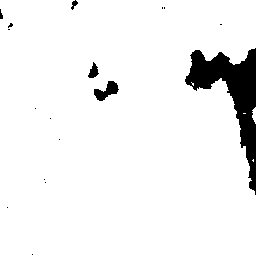

In [18]:
# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [19]:
class orthosSequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths,smooth = 0):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.smooth = smooth

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = gaussian_filter(img, sigma=(self.smooth,self.smooth,0))
        if self.target_img_paths is None:
            return x
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)/255.
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        #print("target : ",y.min(), y.max(), flush=True)
        return x, y

In [20]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [21]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

In [22]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = build_resnet50_unet(img_size + (3,))
print(model.summary())

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                 

In [23]:
import random

# Split our img paths into a training and a validation set
val_samples = 50
train_samples = len(input_img_paths)-val_samples
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]
train_input_img_paths = train_input_img_paths[:train_samples]
train_target_img_paths = train_target_img_paths[:train_samples]

# Instantiate data Sequences for each split
train_gen = orthosSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths, smooth = sigma)
val_gen   = orthosSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths, smooth = sigma)

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

In [24]:
len(input_img_paths)

500

In [25]:
len(train_input_img_paths[:train_samples])

450

In [46]:
len(train_gen)

14

In [27]:
len(val_gen)

1

In [28]:
# Train the model, doing validation at the end of each epoch.
epochs = 2
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/2
14/14 [==============================] - ETA: 0s - loss: 0.3541 - binary_accuracy: 0.8311 

C:\Users\adelabrosse\.conda\envs\inrae_seg_env\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 425s 29s/step - loss: 0.3541 - binary_accuracy: 0.8311 - val_loss: 1.9945 - val_binary_accuracy: 0.7029
Epoch 2/2
14/14 [==============================] - 410s 29s/step - loss: 0.2014 - binary_accuracy: 0.9184 - val_loss: 9.4570 - val_binary_accuracy: 0.6842


In [59]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [61]:
os.path.exists(model_dir)

True

In [60]:
model_dir

'/données/output_model/'

In [81]:
# model.save((model_dir+'Resnet50-Unet_train-'+str(num_samples)+'_epochs-'+str(epochs)+'_sigma-'+str(sigma)+'_seed-'+str(seed)).replace('.', '_'))
model = keras.models.load_model(model_dir+'Resnet50-U-net_train-65536_seed-1337')

In [65]:
len(val_input_img_paths)

50

In [82]:
# Generate predictions for all images in the validation set

val_gen = orthosSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
model.evaluate(val_gen)
val_preds = model.predict(val_gen)
for idx in tqdm(range(len(val_preds))):
    # print(idx)
    keras.preprocessing.image.save_img(output_dir+os.path.basename(val_input_img_paths[idx])[:-3]+"png",val_preds[idx]*255)


# for i in range(len(val_input_img_paths)):
#    keras.preprocessing.image.save_img('/Users/pmeurice/Desktop/tmp/'+os.path.basename(val_input_img_paths[i]),val_gen[i][0][0])

1/1 [==============================] - 8s 8s/step


100%|█████████| 32/32 [00:00<00:00, 273.78it/s]


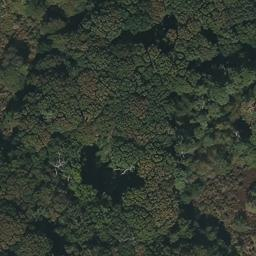

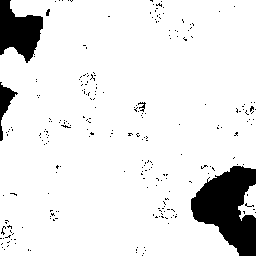

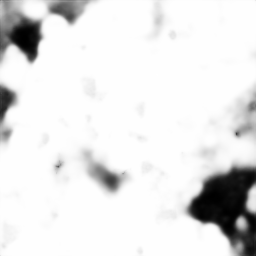

In [83]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    #mask = np.argmax(val_preds[i], axis=-1)
    #mask = np.expand_dims(val_preds[i], axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(val_preds[i]*255))
    display(img)


# Display results for validation image #10
i = 15
# for i in range(100,200,10):
# Display input image
display(Image(filename=val_input_img_paths[i]))
# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

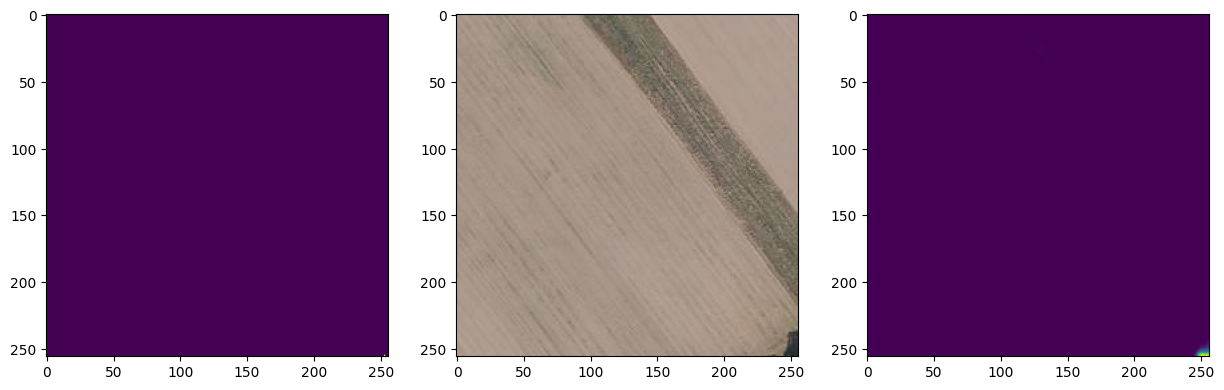

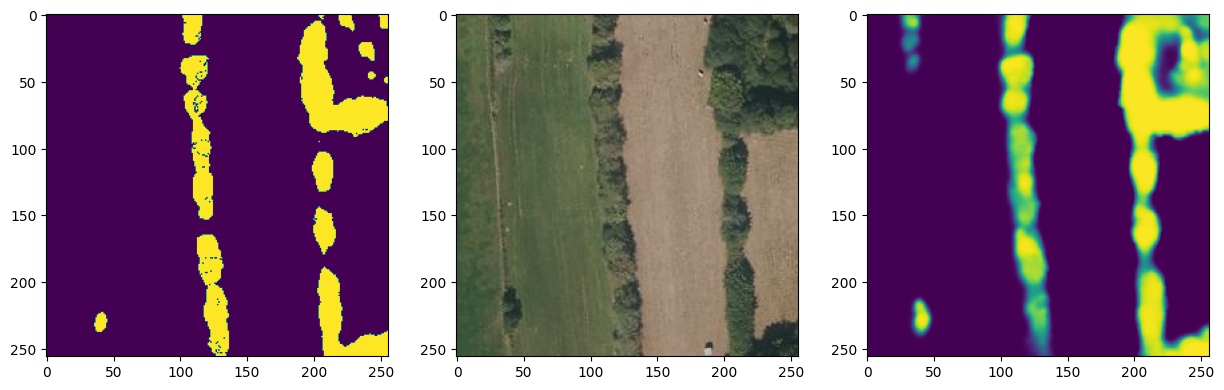

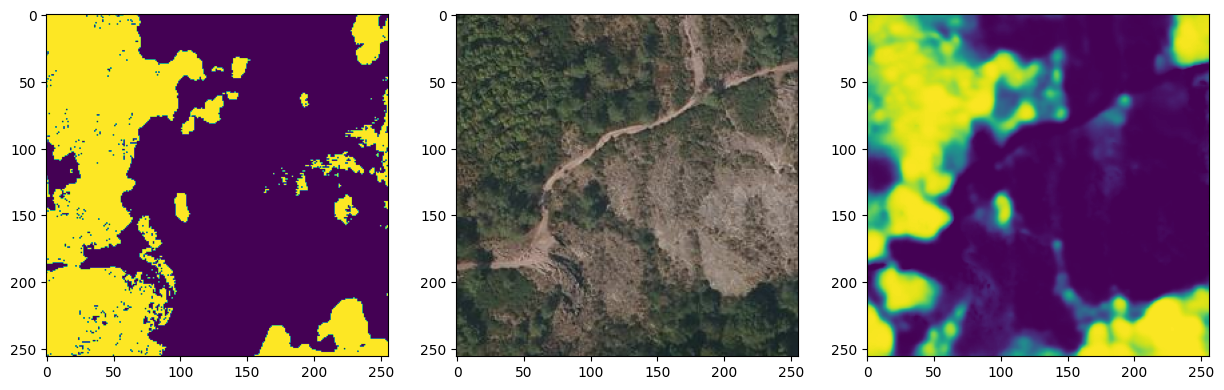

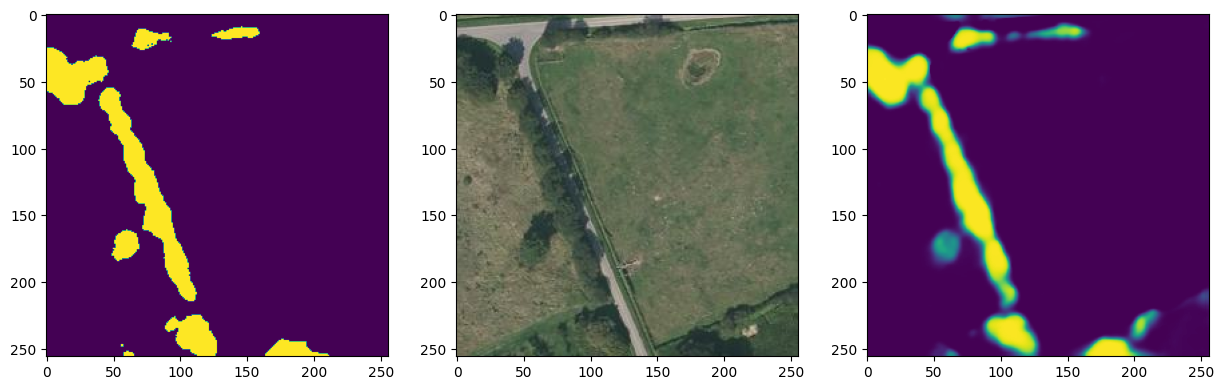

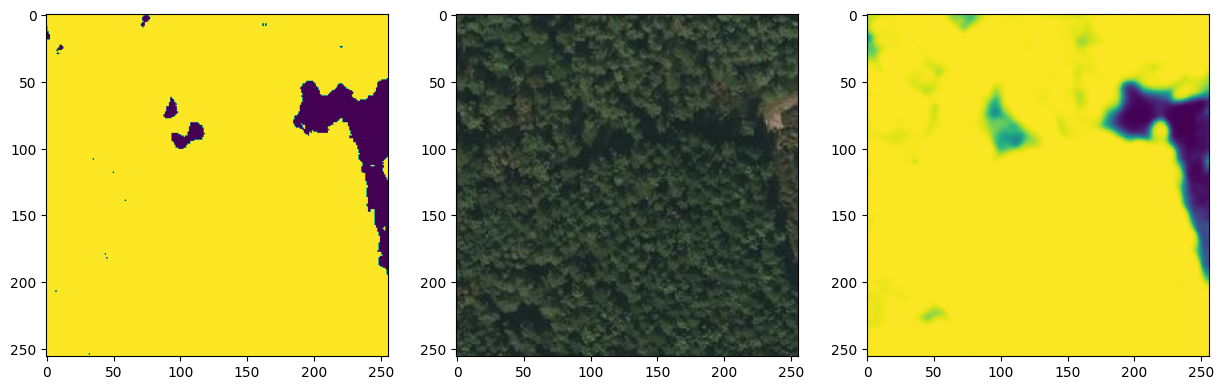

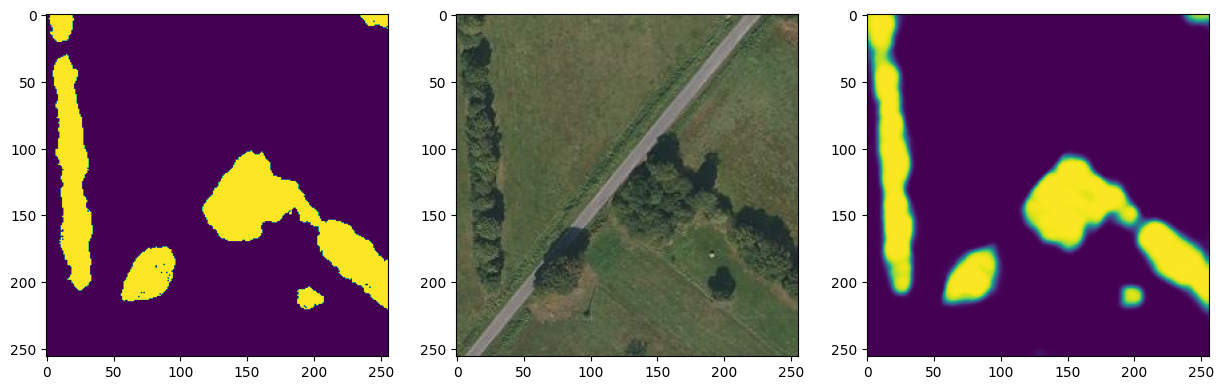

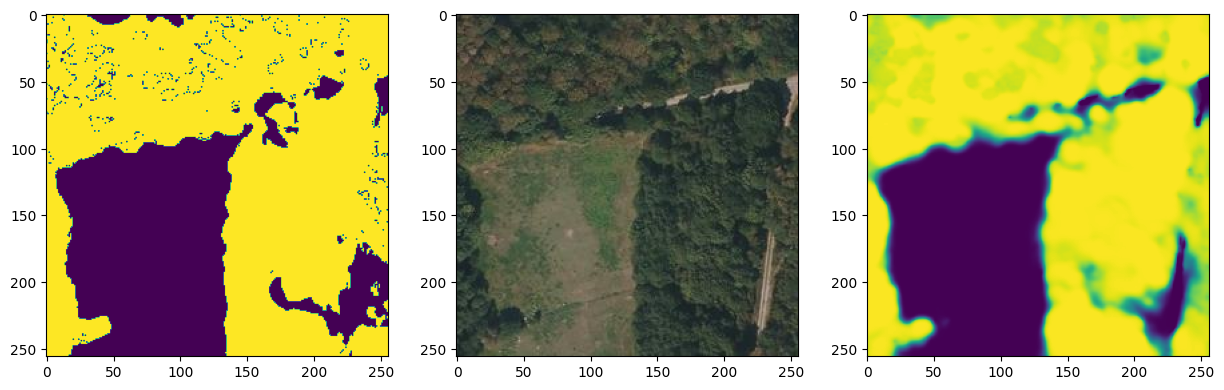

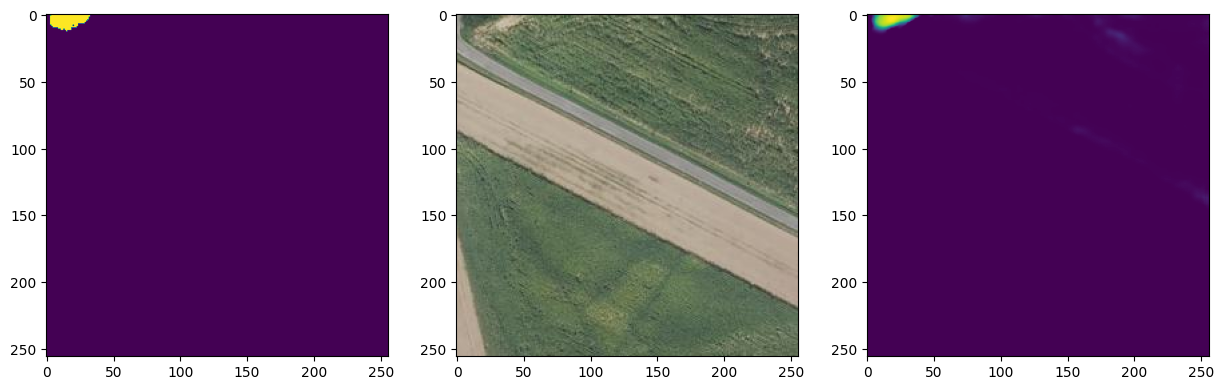

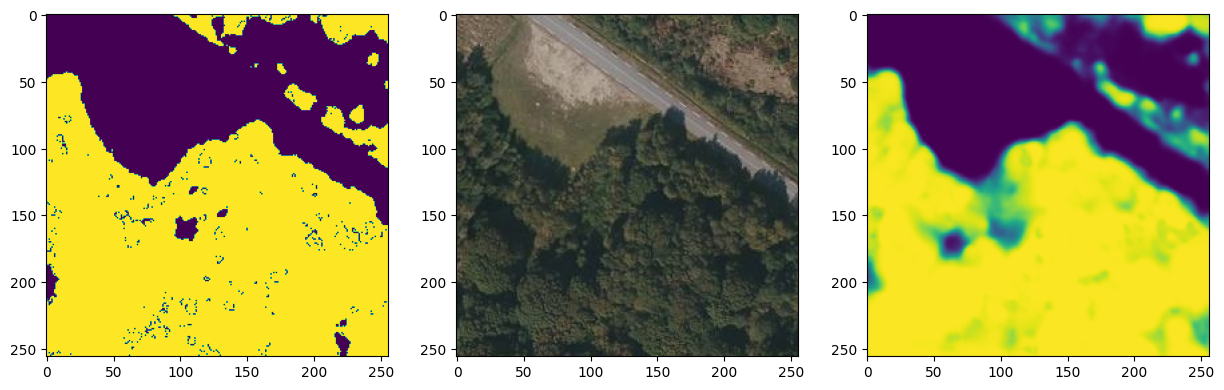

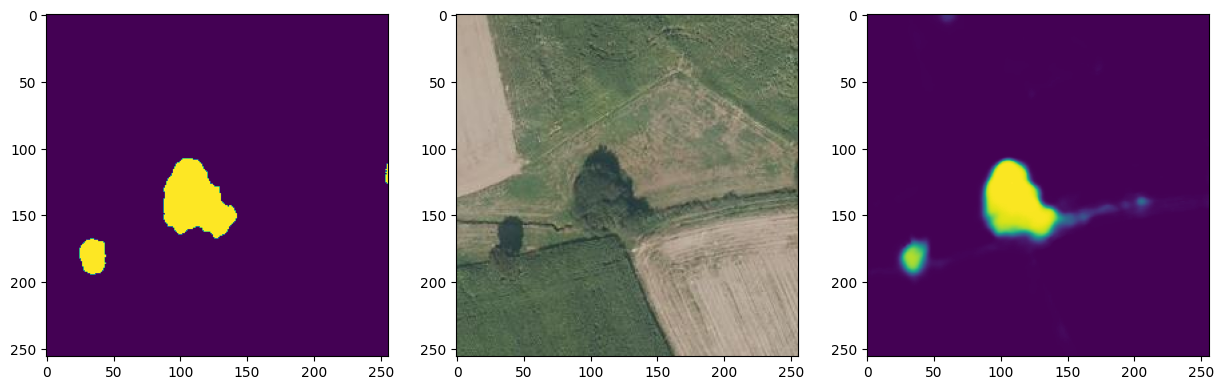

In [84]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
for i in range(10):
    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(15)
    ax[0].imshow(mpimg.imread(val_target_img_paths[i]))
    ax[1].imshow(mpimg.imread(val_input_img_paths[i]))
    ax[2].imshow(mpimg.imread(output_dir+os.path.basename(val_input_img_paths[i])[:-3]+"png"))